# 1. Loading Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#!git clone https://github.com/frau-web/nlp_short_story_generator

fatal: destination path 'nlp_short_story_generator' already exists and is not an empty directory.


In [6]:
# Install required libraries

!pip install tokenizers
!pip install transformers 

!pip install fastai==2.0.15
!pip install fastai2==0.0.30
!pip install fastcore==1.0.16

!pip install -Uqq fastbook

# downgrading to Pytorch 1.6 to prevent AttributeError: '_FakeLoader' object has no attribute 'persistent_workers'
# https://forums.fast.ai/t/attributeerror-fakeloader-object-has-no-attribute-persistent-workers/81167/5
!pip install torch==1.6.0 torchvision==0.7.0 

  Using cached https://files.pythonhosted.org/packages/98/2e/d4dcc69f67b4557c8543a4c65d3e136b1929b01136b227ceb986e2596825/fastai-2.0.15-py3-none-any.whl
ERROR: fastbook 0.0.16 has requirement fastai>=2.1, but you'll have fastai 2.0.15 which is incompatible.
  Found existing installation: fastai 2.3.1
    Uninstalling fastai-2.3.1:
      Successfully uninstalled fastai-2.3.1
  Using cached https://files.pythonhosted.org/packages/99/c9/bd299caa1f1c002495bc9ffb98d31605e78a131a2ba3ba66a2682a7ab245/fastcore-1.0.16-py3-none-any.whl
ERROR: nbdev 1.1.14 has requirement fastcore>=1.3.19, but you'll have fastcore 1.0.16 which is incompatible.
ERROR: fastrelease 0.1.11 has requirement fastcore>=1.3.13, but you'll have fastcore 1.0.16 which is incompatible.
ERROR: fastbook 0.0.16 has requirement fastai>=2.1, but you'll have fastai 2.0.15 which is incompatible.
  Found existing installation: fastcore 1.3.20
    Uninstalling fastcore-1.3.20:
      Successfully uninstalled fastcore-1.3.20
  Using cac

In [7]:
# Importing required libraries
import pandas as pd

from fastai.text.all import *

import fastbook
from fastbook import *
fastbook.setup_book()

In [8]:
# Import GPT2 pretrained model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load pre-trained model (weights)
pretrained_weights = 'gpt2-medium'

# Define tokenizer and model
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights, add_prefix_space=True)    # for documentation: https://huggingface.co/transformers/_modules/transformers/tokenization_gpt2.html

gpt2 = GPT2LMHeadModel.from_pretrained(pretrained_weights)   

In [9]:
# Set the model in evaluation mode to deactivate the DropOut modules, IMPORTANT to have reproducible results during evaluation!
gpt2.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2):

# 2. Generating a story using GPT-2 (Baseline)

In [10]:
# Provided by evaluation/story-generator application
seed = "In a small village in the forest lived a boy with his cat and his dog."
max_len = 350

In [11]:
# Generate Output

seed = seed
max_len = max_len

my_model = gpt2
MAX_LEN = 100
TEMP = 0.9     # Temperature is used to control the randomness of predictions by scaling the logits before applying softmax (small (0.2): model is more confident but also more conservative, large( 1.0): more diversity but also more mistakes)
TOP_K = 40
TOP_P = 0.85
NUM_SEQ = 1


def gen_output(sample_outputs):
  for i, sample_output in enumerate(sample_outputs):
    print("{}: {}...".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))

def gen_story(my_model, seed, max_len):

  # take input
  prompt_ids = tokenizer.encode(seed)
  inp = tensor(prompt_ids)[None]#.cuda() # un-do .cuda() if no GPU available
 
  # generate output
  sample_outputs = my_model.generate(
                              inp,
                              do_sample = True, 
                              max_length = MAX_LEN,     
                              temperature = TEMP,
                              top_k = TOP_K, 
                              top_p = TOP_P, 
                              num_return_sequences = NUM_SEQ,

  )

  # Print Output
  for i, sample_output in enumerate(sample_outputs):
    print("{}: {}...".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))
    return

In [9]:
# Run if RuntimeError: Input, output and indices must be on the current device 
#device = "cuda:0"
#gpt2 = gpt2.to(device)

In [10]:
# Generate output
my_model = gpt2                    # insert model for text generation

gen_story(my_model,seed,max_len)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog. On the morning of the day the boy was to die he went to the window and looked out. He was surprised to see a flock of birds coming in. He ran up to them and asked them if he could play with them. The birds were quite frightened, so the boy did as he was told and put them in his cage. They did not do any harm, and after a few hours the boy was...


# 3. Fine-tuning GPT-2 with children stories

### 3.1 Preprocessing training text

In [3]:
## Import the data (one sentence per line)
#path = "/content/nlp_short_story_generator/data/input_stories_toddlerpluschildren.txt" #within cloned git repo

path = "/content/gdrive/MyDrive/NLP/data/input_stories_toddlerpluschildren.txt"

string = []    
with open(path, "r") as f:
    full_text = f.read()
    for l in re.split(r"(\.)", full_text):
        if l != ".":
            string.append(l + ".")

df = pd.DataFrame(string).rename(columns = {0: "text"})
df.head()

NameError: ignored

In [13]:
# Clean text
def clean_text(df):
  df = df.drop(df[df["text"].str.isupper()].index)        # remove headlines and "THE END" - since written in uppercase letters
  df['text'] = df['text'].str.replace('\n', ' ')          # removes linebreaks \n and replaces it with whitespace
  df['text'] = df['text'].str.replace('_', ' ')
  df['text'] = df['text'].str.replace('--', ',')
  return df


df = clean_text(df)

df.sample(10)

,text
710,His white hair turned black and teeth grew in his mouth.
486,You must be Thrym's wife.
244,Thor killed a big ox and put the pieces into a pot.
551,Then he came to the land Colchis.
1162,"She borrowed a small saucer, and scooped up the dough with her paws."
523,Thrym stepped back.
599,They were as high as a big hill.
447,They did not like to hear the birds sing.
101,The little tree woke and saw its glass leaves.
128,She had no hat on.


In [14]:
# Split into test and train
from sklearn.model_selection import train_test_split

train_test_ratio = 0.9
#train_valid_ratio = 7/9
df_full_train, df_test = train_test_split(df, train_size = train_test_ratio, random_state = 1)
#df_train, df_valid = train_test_split(df_full_train, train_size = train_valid_ratio, random_state = 1)

### 3.2 Tokenize and numericalize training text

In [15]:
# To process this data to train a model, we need to build a Transform that will be applied lazily.

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [16]:
# Test of the class TransformersTokenizer of fastai with tokenizer
tokenizer_fastai = TransformersTokenizer(tokenizer)
text = df.text[998]
tokens_ids = tokenizer_fastai.encodes(text)
tokens = tokenizer_fastai.tokenizer.convert_ids_to_tokens(tokens_ids)

print('input text:',TitledStr(text))
print('text tokens:',TitledStr(tokens))
print('text tokens_ids:',TitledStr(tokens_ids))
print('output text:',TitledStr(tokenizer_fastai.decodes(tokens_ids)))

input text:    Lucie ran on, and on.
text tokens: ['Ġ', 'Ġ', 'ĠLuc', 'ie', 'Ġran', 'Ġon', ',', 'Ġand', 'Ġon', '.']
text tokens_ids: tensor([ 220,  220, 7598,  494, 4966,  319,   11,  290,  319,   13])
output text:    Lucie ran on, and on.


In [17]:
# Creating Dataset and Dataloader
# We gather all texts in one numpy array (since it will be easier to use this way with fastai)
all_texts = np.concatenate([df_full_train["text"].values, df_test["text"].values])

# We define the split between training and validation data
splits = [range_of(df_full_train), list(range(len(df_full_train), len(all_texts)))]

# We create the tls [WIP - EXPLAIN WHAT TLS IS]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [18]:
tls.train[0],tls.valid[0]

(tensor([  220,   220,   679, 34351,   510,   290,   510,    26,   475,   878,   339,  4251,   262, 18205,  1681,  1353,   339,  1625,   284,   257,  1295,   810,  8276,   550, 37222,  2945,   257,
          7815,   287,   262,  3355,    13]),
 tensor([ 220,  220,  317, 1310, 2872, 2576,  373, 2491,  287,  262, 4675,   13]))

In [19]:
show_at(tls.train, 345)

   'Hold tight to me, Helle,' he said.


In [20]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [21]:
dls.show_batch(max_n=2)

,text,text_
0,"The house looked as if it would fall down. ''How big your ears are, grandma. She did not sleep for eight nights. Tom Kitten took another big jump off the bar, and landed on a ledge high up inside the chimney, knocking down some soot into the fender. The dragon ate them all and went to sleep. He came up the rockery by degrees, breaking the ferns, and shedding buttons right and left. Then great Agrippa foams with rage Look at him on this very page! He seizes Arthur, seizes Ned, Takes William by his little head; And they may scream and kick and call, Into the ink he dips them all;","The house looked as if it would fall down. ''How big your ears are, grandma. She did not sleep for eight nights. Tom Kitten took another big jump off the bar, and landed on a ledge high up inside the chimney, knocking down some soot into the fender. The dragon ate them all and went to sleep. He came up the rockery by degrees, breaking the ferns, and shedding buttons right and left. Then great Agrippa foams with rage Look at him on this very page! He seizes Arthur, seizes Ned, Takes William by his little head; And they may scream and kick and call, Into the ink he dips them all;"
1,"a nice field of turnips. When he woke up, he looked and felt like a young man. He gave the ring to Odin. They invited him to stay to dinner. and Mrs. His mother sewed them on again. All the gods came around to see. By the tree was a dragon. One day they were playing in the garden. He took a long pole to hit the eagle. They said, 'It will be just the things with which to keep the Frost Giants out of Asgard. It was now time for Jason and his friends to go away. Then the gods were very cross. 'Now this is what had been happening to Tom Kitten, and it shows how very unwise it is to go up","nice field of turnips. When he woke up, he looked and felt like a young man. He gave the ring to Odin. They invited him to stay to dinner. and Mrs. His mother sewed them on again. All the gods came around to see. By the tree was a dragon. One day they were playing in the garden. He took a long pole to hit the eagle. They said, 'It will be just the things with which to keep the Frost Giants out of Asgard. It was now time for Jason and his friends to go away. Then the gods were very cross. 'Now this is what had been happening to Tom Kitten, and it shows how very unwise it is to go up a"


### 3.3 Train GPT-2 model with prepared training text (fine-tuning)

In [22]:
# We use callbacks in case we want to alter the behavior of the training loop 
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
gpt2.train()

In [24]:
learn = Learner(dls, 
                gpt2, 
                loss_func=CrossEntropyLossFlat(), 
                cbs=[DropOutput],  #drop_mult=0.3, #             # Regularization
                metrics=[accuracy, Perplexity()])#.to_fp16()   # Accuracy metric: to see how many times our model is right when trying to predict the next word, perplexity: exponential of the loss (i.e., torch.exp(cross_entropy))

In [25]:
# Check how good the model is doing without any fine-tuning step
learn.validate()

(#3) [3.4752237796783447,0.38069939613342285,32.305057525634766]

(#3) [3.4752237796783447,0.38069939613342285,32.305057525634766]

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=1.5848931980144698e-06)

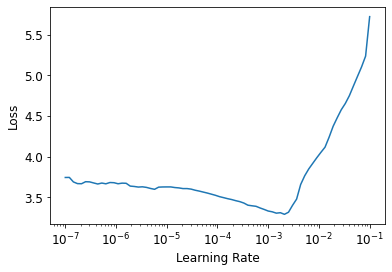

In [26]:
learn.lr_find()

Image of the learning rate: 
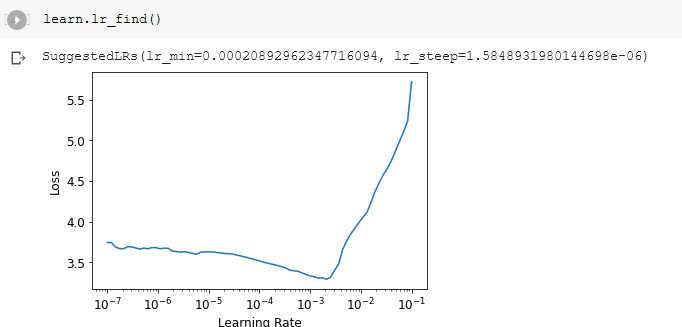

In [27]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.322489,3.049164,0.422785,21.097696,12:53


0 	3.322489 	3.049164 	0.422785 	21.097696 	12:53

In [28]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.394812,2.990069,0.424876,19.887058,12:54


epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	2.394812 	2.990069 	0.424876 	19.887058 	12:54

### 3.4 Save model

In [29]:
# https://fastai1.fast.ai/tutorial.inference.html

model_path = "/content/gdrive/MyDrive/NLP/model/"

learn.export(model_path + 'gpt2-finedtuned.pkl')

### 3.5 Generate Shortstory with fine-tuned GPT-2 model

In [ ]:
## https://stackoverflow.com/questions/27732354/unable-to-load-files-using-pickle-and-multiple-modules

#import pickle

#class CustomUnpickler(pickle.Unpickler):

#    def find_class(self, module, name):
#        if name == 'Manager':
#            from settings import Manager
#            return Manager
#        return super().find_class(module, name)

In [31]:
# Load model

gpt2_tuned = load_learner(model_path + 'gpt2-finedtuned.pkl')

In [32]:
# Generate output
my_model = gpt2_tuned                 # insert model for text generation

gen_story(my_model,seed,max_len)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.     It was a pretty dark night.    She thought it best to hide in the rocks.   McGregor's brother had been killed.    McGregor's wife was dead.   But he could not hurt you.   The gods were afraid.   He said to Brok, 'Now, Brok, let me have your things.     ...


# 4. Further Fine-tuning: Gradual unfreezing

In [22]:
# Using a callback to alter the behavior of the training loop 
# (dropping some additional activations resulting from the hugging face model)

class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

#### (1) Splitter: getting the layer groups

In [23]:
gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2):

In [24]:
# Example of a decoder block (attention head)
gpt2.transformer.h[0]

Block(
  (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [25]:
# Split a GPT2 model in 4 groups for differential learning rates (Code from Finetuning English GPT2 to any language)

def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    # Fourth layers group : embeddings matrices wte and wpe + LayerNorm at the model output
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)

#### (2) Creating our Learner 

In [26]:
# Create the learner (basic class for handling the training loop)
learn_tuned = Learner(dls, gpt2, loss_func=CrossEntropyLossFlat(),
                splitter = splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()])#.to_fp16()

In [27]:
# Check the number of parameters groups and the hyperparameters values
learn_tuned.create_opt()
print(f'number of parameters groups: {len(learn_tuned.opt.param_groups)}')

# ... and the list of Learning Rates (before its atualization by the Optimizer of the function fit_one_cycle())
for i,h in enumerate(learn_tuned.opt.hypers):
    print(i,h)


number of parameters groups: 4
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}


In [28]:
# loss, accuracy, Perplexity() of validation dataset - without any fine-tuning
%%time
learn_tuned.validate()

CPU times: user 28.5 s, sys: 1.81 s, total: 30.3 s
Wall time: 30.1 s


(#3) [3.4752237796783447,0.38069939613342285,32.305057525634766]

(1) CPU times: user 33.5 s, sys: 1.16 s, total: 34.6 s
Wall time: 34.6 s

(#3) [3.325554132461548,0.39338234066963196,27.814407348632812]

(2) CPU times: user 28.5 s, sys: 736 ms, total: 29.3 s
Wall time: 29.2 s

(#3) [3.1370880603790283,0.4250364303588867,23.03668785095215]

(3) CPU times: user 28.5 s, sys: 1.81 s, total: 30.3 s
Wall time: 30.1 s

(#3) [3.4752237796783447,0.38069939613342285,32.305057525634766]

In [29]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog. He was a boy, very gentle and kind. He was a kind man, very devoted to his wife and family, and he was very gentle with his dog. The dog had a big white nose. He looked at him and smiled, as though it were his friend. The boy's wife was surprised at this, and the boy told her that the dog was his. She knew that she should not look at...


#### *(2.1) Freezing all layers but the last layers group (do not freeze wte, wpe embeddings matrices and last LayerNorm)*

In [30]:
learn_tuned.freeze()
learn_tuned.summary()

GPT2LMHeadModel (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 1024      
Embedding                                 51463168   True      
Embedding                                 1048576    True      
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     4 x 256 x 3072      
Conv1D                                    3148800    False     
Conv1D                                    1049600    False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     4 x 256 x 4096      
Conv1D                                    41984

In [31]:
%%time
#learn_tuned.lr_find()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


Image of the learning rate:
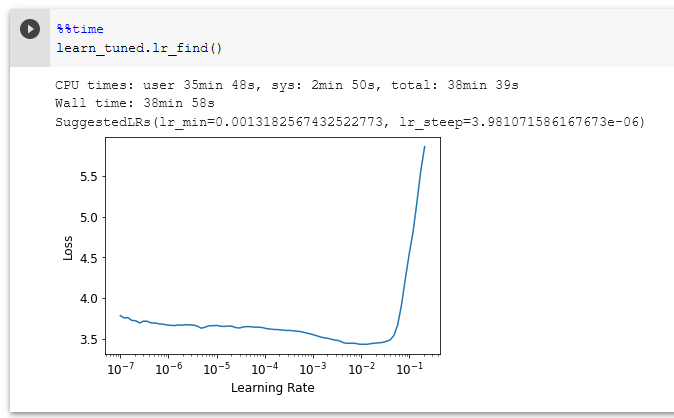

In [32]:
learn_tuned.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.798382,3.465683,0.380368,31.998306,11:06


epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	3.780852 	3.469479 	0.386255 	32.120014 	11:07

(3) CPU times: user 28.5 s, sys: 1.81 s, total: 30.3 s
Wall time: 30.1 s

(#3) [3.4752237796783447,0.38069939613342285,32.305057525634766]

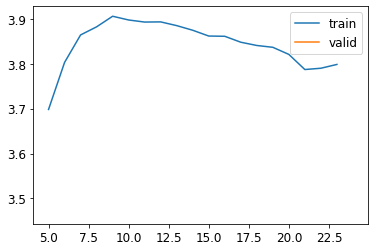

In [33]:
# Plotting training loss
learn_tuned.recorder.plot_loss()

In [34]:
# Save model
model_path = "/content/gdrive/MyDrive/NLP/model/"

learn_tuned.export(model_path + 'gpt2_1epoch_lr1e-2.pkl')

In [35]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.     They searched for a house full of apples, and a big chest of drawers.   He went to sleep.     They took their beds in the little girl's arms.      They wanted to eat her, but she would have to fight her.         They went to see a fine old wolf.    ...


#### *(2.2) Freezing all layers but the last 2 layers groups)*

In [36]:
learn_tuned.freeze_to(-2)
learn_tuned.summary()

GPT2LMHeadModel (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 1024      
Embedding                                 51463168   True      
Embedding                                 1048576    True      
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     4 x 256 x 3072      
Conv1D                                    3148800    False     
Conv1D                                    1049600    False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     4 x 256 x 4096      
Conv1D                                    41984

In [37]:
# Discriminative-layer-training: https://forums.fast.ai/t/what-does-the-slice-lr-mean-in-fit-one-cycle/60896/5
learn_tuned.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3)) # Half of previous LR

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.017143,3.222564,0.404115,25.092369,11:55


epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	2.972569 	3.219555 	0.405902 	25.016983 	11:55

epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	3.017143 	3.222564 	0.404115 	25.092369 	11:55

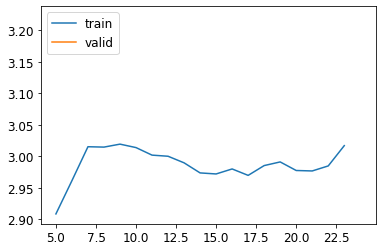

In [38]:
# Plotting training loss
learn_tuned.recorder.plot_loss()

In [39]:
# Save model
model_path = "/content/gdrive/MyDrive/NLP/model/"

learn_tuned.export(model_path + 'gpt2_2epoch_lr5e-3.pkl')

In [40]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   He huffed and he huffed and he huffed and he huffed and he huffed and he huffed.   She said to him, 'Now, children, you shall have it.   The next day, the squirrels came and went.   But one day the eagle went up and flew away.   And the eagle was a turkey.   The king was...


#### *(2.3) Freezing all layers but the last 3 layers groups)*

In [41]:
learn_tuned.freeze_to(-3)
learn_tuned.summary()

GPT2LMHeadModel (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 1024      
Embedding                                 51463168   True      
Embedding                                 1048576    True      
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     4 x 256 x 3072      
Conv1D                                    3148800    False     
Conv1D                                    1049600    False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     4 x 256 x 4096      
Conv1D                                    41984

In [42]:
learn_tuned.fit_one_cycle(1, slice(2.5e-3/(2.6**4),2.5e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.358402,3.131221,0.424981,22.901917,12:45


epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	2.271448 	3.098387 	0.420617 	22.162186 	12:51

epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	2.358402 	3.131221 	0.424981 	22.901917 	12:45

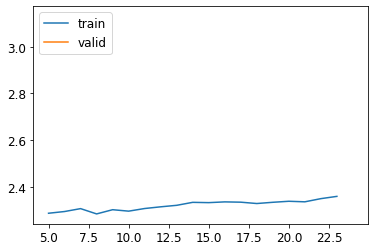

In [43]:
# Plotting training loss
learn_tuned.recorder.plot_loss()

In [44]:
# Save model
model_path = "/content/gdrive/MyDrive/NLP/model/"

learn_tuned.export(model_path + 'gpt2_3epoch_lr25e-3.pkl')

#learn_tuned = load_learner(model_path + 'gpt2_3epoch_lr25e-3.pkl')

In [52]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   When the little tree woke, it had leaves of gold leaves.   But there was nothing to be seen.   He killed the Wolf and ate the sheep.   The duckling was very hungry.   But Loki knew better.   They had a hard time.   Then they brought a ship and took it to the king.   The gods felt very sorry for him...


#### *(2.4) Unfreezing all layers*

In [46]:
learn_tuned.unfreeze()
learn_tuned.summary()

GPT2LMHeadModel (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 1024      
Embedding                                 51463168   True      
Embedding                                 1048576    True      
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     4 x 256 x 3072      
Conv1D                                    3148800    True      
Conv1D                                    1049600    True      
Dropout                                                        
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     4 x 256 x 4096      
Conv1D                                    41984

In [47]:
learn_tuned.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.919646,3.141384,0.426476,23.135862,13:41
1,1.781802,3.190560,0.426995,24.302023,13:30


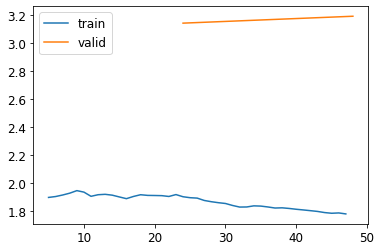

In [48]:
#hide
learn_tuned.recorder.plot_loss()

In [49]:
# Save model
model_path = "/content/gdrive/MyDrive/NLP/model/"

learn_tuned.export(model_path + 'gpt2_5epoch_lr5e-4.pkl')

In [50]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.  'They were in bed when Jason came.   But Nutkin ran after him, and after him came Nutkin and his little Pig.   But what a wind! what a wind! oh, how it whistles! oh, how it whistles! oh, how it whistles!   'Oh, children, let us come in and get some, if you please'm;...
